In [5]:
import math
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras

In [ ]:
class DataGenerator(keras.utils.Sequence):
    """
    
    객체 생성 시 필요한 인자 정하기
    배치 사이즈, 데이터를 폴더별로 저장했기 때문에 csv파일 경로 
    fold
    학습인지를 다지는 mode
    """
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.fold = fold
        self.mode = mode
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == fold]
            
        self.on_epoch_end()
        
    # batch가 몇 개 있는지 확인, 남는 데이터 위해 올림 사용
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
    
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
    
    
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            image = cv2.imread(f"C:\\Users\\User\\Downloads\\images\\images\\{file_name}.jpg")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            image = image / 255.0
            
            label = int(r['species']) -1
            
            batch_x.append(image)
            batch_y.append(label)
        return batch_x, batch_y
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [7]:
csv_path = './kfolds.csv'
train_generator = DataGenerator(
    batch_size=9,
    csv_path=csv_path,
    fold=1,
    image_size=256,
    mode='train',
    shuffle=True
)
print(len(train_generator)*9)

7353


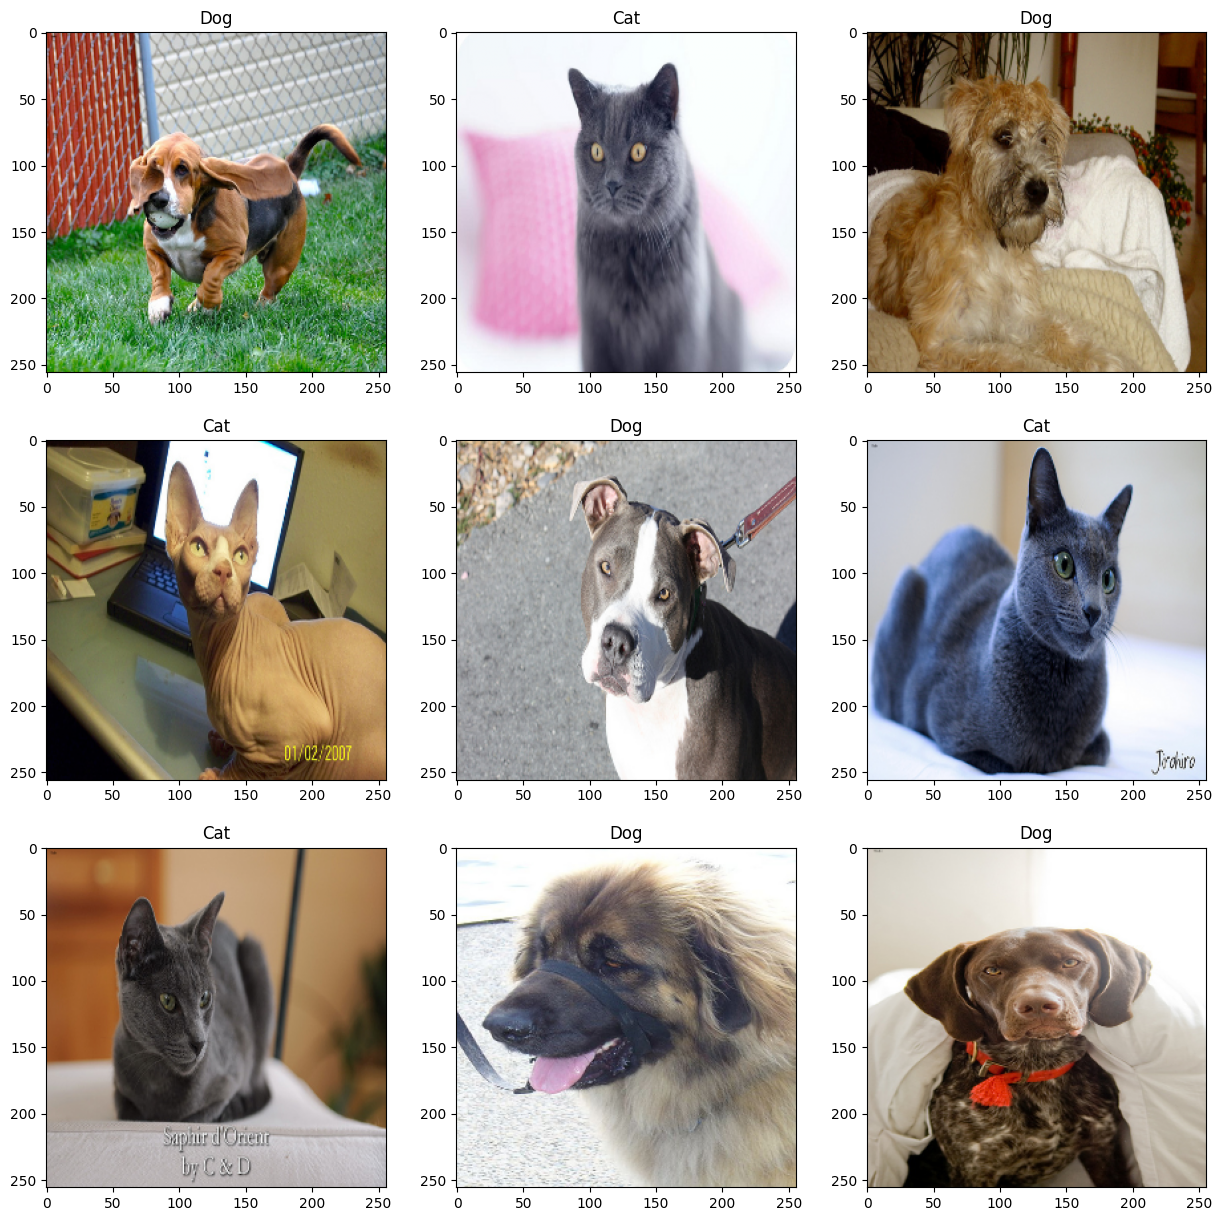

In [8]:
class_name = ['Cat', 'Dog']

for batch in train_generator:
    X, y = batch
    plt.figure(figsize=(15, 15))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(X[i])
        
        plt.title(class_name[y[i]])
        plt.axis
    break

In [12]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

def get_sequential_model(input_shape):
    model = keras.Sequential(
        [
            layers.Input(input_shape),
            
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same'),
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same'),
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            
            layers.GlobalAveragePooling2D(),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ]
    )
    return model

input_shape = (256, 256, 3)
model = get_sequential_model(input_shape)

model.summary()   

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,569 (1.06 MB)

 Trainable params: 277,185 (1.06 MB)

 Non-trainable params: 384 (1.50 KB)

In [14]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, image_size, fold, model='train', shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.fold = fold
        self.model = model
        
        self.df = pd.read_csv(csv_path)
        
        if self.model == 'train':
            self.df = self.df[self.df['fold'] != fold]
        elif self.model == 'val':
            self.df = self.df[self.df['fold'] == fold]
            
        self.on_epoch_end()
        
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
    
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
    
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            image = cv2.imread(f"C:\\Users\\User\\Downloads\\images\\images\\{file_name}.jpg")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            image = image / 255.0
            
            label = int(r['species']) - 1
            
            batch_x.append(image)
            batch_y.append(label)
            
        return batch_x, batch_y
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [17]:
csv_path = './kfolds.csv'
train_generator = DataGenerator(
    fold=1,
    model='val',
    csv_path=csv_path,
    batch_size=128,
    image_size=256,
    shuffle=True
)
valid_generator = DataGenerator(
    fold=1,
    model='val',
    csv_path=csv_path,
    batch_size=128,
    image_size=256,
    shuffle=True
)

In [21]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=3,
    verbose=1
)

Epoch 1/3


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 1.0000 - loss: 0.5764 - val_accuracy: 1.0000 - val_loss: 0.6399
Epoch 2/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 1.0000 - loss: 0.5755 - val_accuracy: 1.0000 - val_loss: 0.6331
Epoch 3/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 1.0000 - loss: 0.5712 - val_accuracy: 1.0000 - val_loss: 0.6218


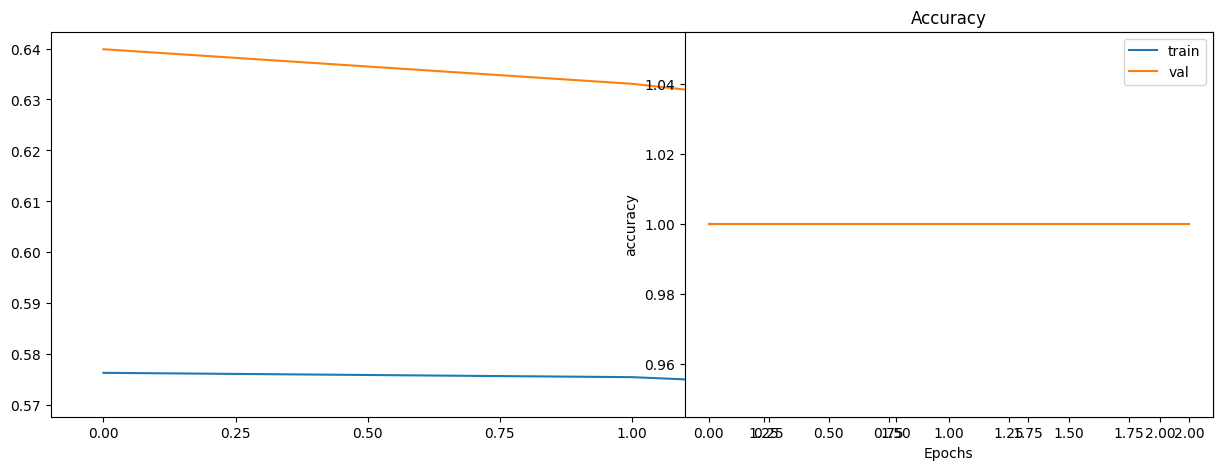

In [22]:
import matplotlib.pyplot as plt
history = history.history

plt.figure(figsize=(15, 5))
plt.subplot
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.show()